In [2]:
import pandas as pd
import pickle
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from haversine import haversine
import folium
from folium import plugins
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import poisson
import statsmodels.api as sm



df_base = pd.read_csv('../kaggle_data/input/train.csv')
weather = pd.read_csv('../kaggle_data/input/weather.csv')
spray = pd.read_csv('../kaggle_data/input/spray.csv')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
#Change everything to datetimes:
    
df_base.Date = pd.to_datetime(df_base.Date)
weather.Date = pd.to_datetime(weather.Date)
spray.Date = pd.to_datetime(spray.Date)

In [7]:
train, test = train_test_split(df_base, test_size =0.20, random_state=42)

In [8]:


mdf = train.groupby(['Latitude', 'Longitude','Date','Species'])[['NumMosquitos']].sum()

In [25]:
tdf = train.groupby(['Latitude', 'Longitude','Species', 'Address'], sort=True,
                 as_index = True)[['NumMosquitos', 'WnvPresent']].sum().reset_index()

tdf.head()

,Latitude,Longitude,Species,Address,NumMosquitos,WnvPresent
0,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",53,0
1,41.644612,-87.604498,CULEX PIPIENS/RESTUANS,"East 138th Street, Riverdale, IL 60827, USA",64,0
2,41.644612,-87.604498,CULEX RESTUANS,"East 138th Street, Riverdale, IL 60827, USA",1,0
3,41.659112,-87.538693,CULEX PIPIENS,"4000 East 130th Street, Chicago, IL 60633, USA",293,3
4,41.659112,-87.538693,CULEX PIPIENS/RESTUANS,"4000 East 130th Street, Chicago, IL 60633, USA",735,0


In [10]:
import folium
from folium import plugins

In [11]:
tdf[tdf['Species']=='CULEX PIPIENS'].head()


bounds = (tdf.Longitude.min(), tdf.Longitude.max())

In [12]:
bounds

(-87.930995, -87.531635)

In [17]:
Chicago = folium.Map()

locations = tdf[['Latitude','Longitude', 'NumMosquitos']].as_matrix()
Chicago.add_child(plugins.HeatMap(locations, radius=10, min_opacity = 0.5))
# Chicago.add_child(plugins.MarkerCluster(locations))
# Chicago.add_child(plugins.FastMarkerCluster(locations))
Chicago.fit_bounds([[41.644612, -87.930995], [42.01743, -87.531635]])
Chicago

In [15]:
Chicago.get_bounds()
Chicago.zoom_start

1

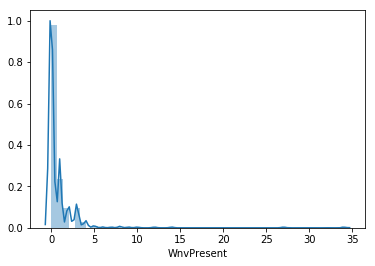

In [18]:
# nonzero = Poisson(tdf['WnvPresent'], tdf[['Latitude', 'Species', 'NumMosquitos']]to

sns.distplot(tdf['WnvPresent'])

In [26]:
tdf['site'] = LabelEncoder().fit_transform(tdf['Address'])
tdf.head()

,Latitude,Longitude,Species,Address,NumMosquitos,WnvPresent,site
0,41.644612,-87.604498,CULEX PIPIENS,"East 138th Street, Riverdale, IL 60827, USA",53,0,120
1,41.644612,-87.604498,CULEX PIPIENS/RESTUANS,"East 138th Street, Riverdale, IL 60827, USA",64,0,120
2,41.644612,-87.604498,CULEX RESTUANS,"East 138th Street, Riverdale, IL 60827, USA",1,0,120
3,41.659112,-87.538693,CULEX PIPIENS,"4000 East 130th Street, Chicago, IL 60633, USA",293,3,56
4,41.659112,-87.538693,CULEX PIPIENS/RESTUANS,"4000 East 130th Street, Chicago, IL 60633, USA",735,0,56


In [130]:
exo = pd.concat([ tdf['NumMosquitos'],pd.get_dummies(tdf['Species'], drop_first=True),pd.get_dummies(tdf['site'], drop_first=True)], axis=1)
exo = sm.add_constant(exo, prepend=False)
endo = tdf['WnvPresent']
glm_gamma = sm.GLM(endo, exo, family=sm.families.Poisson())
glm_results = glm_gamma.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             WnvPresent   No. Observations:                  542
Model:                            GLM   Df Residuals:                      397
Model Family:                 Poisson   Df Model:                          144
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -354.56
Date:                Mon, 05 Mar 2018   Deviance:                       200.28
Time:                        08:56:51   Pearson chi2:                     181.
No. Iterations:                    25                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
NumMosquitos               0.0001   2.44e-05      5.148      0.000    7.78e-05       0.000
CULEX PIPIENS   

In [170]:
pippi=tdf[tdf['Species'].str.contains('PIPIENS')]
pippi.head()

,Latitude,Longitude,Species,NumMosquitos,WnvPresent,site
0,41.644612,-87.604498,CULEX PIPIENS,53,0,0
1,41.644612,-87.604498,CULEX PIPIENS/RESTUANS,64,0,0
3,41.659112,-87.538693,CULEX PIPIENS,293,3,1
4,41.659112,-87.538693,CULEX PIPIENS/RESTUANS,735,0,1
8,41.662014,-87.724608,CULEX PIPIENS,674,4,2


In [175]:
exo = pippi['NumMosquitos']
exo = sm.add_constant(exo, prepend=False)
endo = pippi['WnvPresent']
glm_poisson = sm.GLM(endo, exo, family=sm.families.Poisson())
glm_results = glm_poisson.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             WnvPresent   No. Observations:                  269
Model:                            GLM   Df Residuals:                      267
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -460.85
Date:                Mon, 05 Mar 2018   Deviance:                       535.13
Time:                        09:11:06   Pearson chi2:                     559.
No. Iterations:                     6                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
NumMosquitos     0.0003   1.16e-05     25.479      0.000       0.000       0.000
const            0.1529      0.056      2.742 

In [176]:
exo = pd.concat([pippi['NumMosquitos'], pd.get_dummies(pippi['site'])], axis=1)
exo = sm.add_constant(exo, prepend=False)
endo = pippi['WnvPresent']
fishy = sm.GLM(endo, exo, family=sm.families.Poisson())
catch = fishy.fit()
print(catch.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             WnvPresent   No. Observations:                  269
Model:                            GLM   Df Residuals:                      131
Model Family:                 Poisson   Df Model:                          137
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -244.22
Date:                Mon, 05 Mar 2018   Deviance:                       101.89
Time:                        09:11:15   Pearson chi2:                     78.5
No. Iterations:                    24                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
NumMosquitos     0.0002   3.39e-05      4.642      0.000    9.09e-05       0.000
0              -16.3999   8.01e+04     -0.000 